In [1]:
import json
import numpy as np
import os
from tqdm import tqdm

# Initialize containers for energies
methods = ["opt", "HF", "B3LYP", "sto-3G","basisNN"]
energy_data = {method: [] for method in methods}

# Load the JSON file
file_path = "inference.json"
with open(file_path, "r") as file:
    data = json.load(file)

eigenvalue_l = []
name_l = np.array(data["name"])
print(name_l)
print(len(data["proj"]))
for i in range(len(data["proj"])):
    # Extract the first matrix under the 'proj' key
    i_matrix = np.array(data["proj"][i])

    # Compute the eigenvalues
    eigenvalues = np.linalg.eigvals(i_matrix)
    eigenvalues.sort()
    eigenvalue_l.extend(eigenvalues)
print(len(eigenvalue_l))

['518.json' '553.json' '562.json' '529.json' '500.json' '593.json'
 '531.json' '566.json' '557.json' '597.json' '535.json' '504.json'
 '543.json' '508.json' '539.json' '572.json' '510.json' '521.json'
 '583.json' '576.json' '547.json' '525.json' '587.json' '514.json'
 '509.json' '542.json' '573.json' '538.json' '511.json' '520.json'
 '582.json' '577.json' '546.json' '524.json' '586.json' '515.json'
 '552.json' '519.json' '528.json' '563.json' '501.json' '592.json'
 '530.json' '567.json' '556.json' '596.json' '534.json' '505.json'
 '540.json' '571.json' '598.json' '513.json' '558.json' '580.json'
 '569.json' '522.json' '575.json' '544.json' '584.json' '526.json'
 '517.json' '550.json' '588.json' '561.json' '548.json' '503.json'
 '532.json' '579.json' '590.json' '565.json' '554.json' '536.json'
 '594.json' '507.json' '551.json' '589.json' '560.json' '502.json'
 '549.json' '578.json' '533.json' '591.json' '564.json' '555.json'
 '537.json' '595.json' '506.json' '541.json' '570.json' '599.j

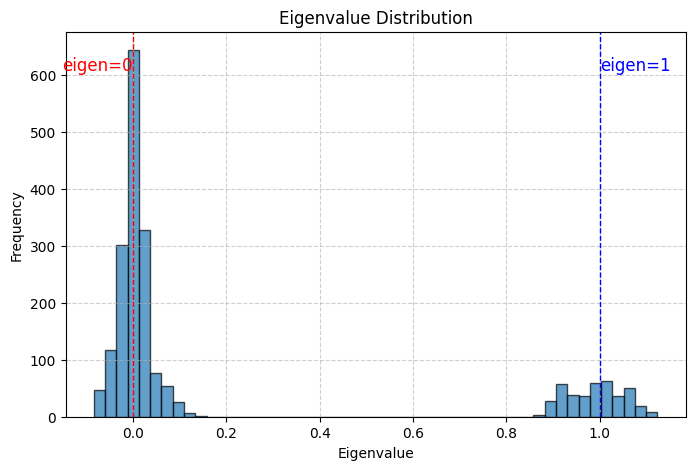

In [2]:
import matplotlib.pyplot as plt

def plot_distribution(eigenvalue_l, bins=50):
    plt.figure(figsize=(8, 5))
    plt.hist(eigenvalue_l, bins=bins, edgecolor='black', alpha=0.7)
    
    # Add vertical dashed lines
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
    plt.axvline(x=1, color='blue', linestyle='--', linewidth=1)
    
    # Add text labels
    plt.text(0, plt.ylim()[1] * 0.9, 'eigen=0', color='red', ha='right', fontsize=12)
    plt.text(1, plt.ylim()[1] * 0.9, 'eigen=1', color='blue', ha='left', fontsize=12)
    
    plt.xlabel('Eigenvalue')
    plt.ylabel('Frequency')
    plt.title('Eigenvalue Distribution')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Example usage
plot_distribution(eigenvalue_l)


In [3]:
from downfolding_methods_pytorch import nelec, norbs, fock_downfolding, Solve_fermionHam, perm_orca2pyscf
from pyscf import gto, scf, dft
import scipy

def calc_basisNN_inp_file(inp_data):
    elements = inp_data['elements']
    coordinates = inp_data['coordinates']
    atoms = [(elements[i], coordinates[i]) for i in range(len(elements))]
    S = gto.M(
        atom=atoms,  # Atomic symbols and coordinates
        basis="cc-pVDZ"
    ).intor("int1e_ovlp")
    sqrtS = scipy.linalg.sqrtm(S).real
    perm = perm_orca2pyscf(
        atom=atoms,  # Atomic symbols and coordinates
        basis="cc-pVDZ"
    )
    
    proj = inp_data['proj']
    proj = perm @ proj @ perm.T
    proj = sqrtS @ proj @ sqrtS
    
    n_fold = norbs(atom=atoms,basis='sto-3g')
    ham = fock_downfolding(n_fold,('self-defined',-proj),False,atom=atoms, basis='cc-pVDZ')
    #E = Solve_fermionHam(ham.Ham_const, ham.int_1bd, ham.int_2bd, nele=nelec(atom=atoms, basis='sto-3G'), method='FCI')[0]
    return ham

print(len(data["proj"]))


with tqdm(total=len(data["proj"]), desc="Processing", dynamic_ncols=True) as pbar:
    for proj, elements, pos in zip(data["proj"], data["elements"], data["pos"]):
        inp_data = {'elements': elements, 'coordinates': pos, 'proj': proj}
        ham = calc_basisNN_inp_file(inp_data)
        print(ham.Ham_const, ham.int_1bd, ham.int_2bd)
        
        pbar.set_postfix({"basisNN_E"})  # Format to 6 decimals for better readability
        pbar.update(1)

100


Processing:   0%|          | 0/100 [00:00<?, ?it/s]

3.073827392274569 tensor([[-1.6516164243,  0.4055707912,  0.0872788561,  0.1278747513],
        [ 0.4055707912, -1.9777353163,  0.1944411240, -0.0388960823],
        [ 0.0872788561,  0.1944411240, -1.7119807850,  0.0587337697],
        [ 0.1278747513, -0.0388960823,  0.0587337697, -0.8282609935]],
       dtype=torch.float64) tensor([[[[ 6.9589137372e-01, -1.1574039744e-01,  1.9882032188e-04,
            1.0295607775e-01],
          [-1.1574039744e-01,  5.0037316693e-01, -1.4298699329e-02,
            5.5498848132e-03],
          [ 1.9882032188e-04, -1.4298699329e-02,  4.9110231497e-01,
           -7.6190438097e-02],
          [ 1.0295607775e-01,  5.5498848132e-03, -7.6190438097e-02,
            5.6192258233e-01]],

         [[-1.1574039744e-01,  8.6982746623e-02, -1.1062086305e-02,
           -6.7839210312e-02],
          [ 8.6982746623e-02, -9.7349569932e-03, -1.3636842069e-02,
           -3.0946410895e-02],
          [-1.1062086305e-02, -1.3636842069e-02, -2.2501515788e-02,
         

NameError: name 'basisNN_E' is not defined

In [ ]:
folder = "/home/hewenhao/Documents/wenhaohe/research/learn_basis/learn_basis/dataset/H4_test"
# collect other energies
for name in name_l:
    # Load the JSON file
    file_path = os.path.join(folder,'obs',name)
    with open(file_path, "r") as file:
        data = json.load(file)
    energy_data['opt'].append(data['opt_E'])
    energy_data['HF'].append(data['HF_E'])
    energy_data['B3LYP'].append(data['B3LYP_E'])
    energy_data['sto-3G'].append(data['sto-3G_E'])


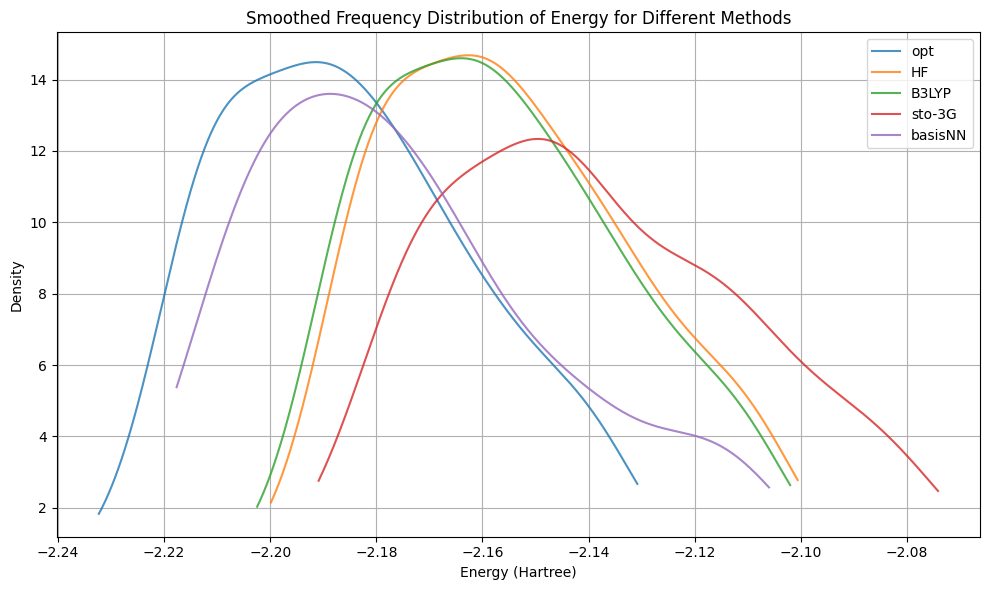

Figure saved as energy_distribution_smooth.png


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Plot the frequency distribution for each method using KDE
plt.figure(figsize=(10, 6))

for method in methods:
    if energy_data[method]:  # Ensure there's data to plot
        # Perform Kernel Density Estimation
        data = np.array(energy_data[method])
        kde = gaussian_kde(data)
        x_vals = np.linspace(data.min(), data.max(), 500)  # Generate x-axis values
        y_vals = kde(x_vals)  # Evaluate KDE for the x-axis values

        # Plot the KDE curve
        plt.plot(x_vals, y_vals, label=method, linewidth=1.5, alpha=0.8)

# Configure the plot
plt.title("Smoothed Frequency Distribution of Energy for Different Methods")
plt.xlabel("Energy (Hartree)")
plt.ylabel("Density")
plt.legend(loc="best")
plt.grid(True)

# Save the plot as a file
output_file = "energy_distribution_smooth.png"
plt.tight_layout()
#plt.savefig(output_file, dpi=300)
plt.show()
plt.close()

print(f"Figure saved as {output_file}")